# Predicting Voter Tendencies Using County Demographics: Analysis of the 2016 Election

## Prepare model

In [1]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import networkx as nx

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/STEDWARDS/MATH-3439-01/Project 2/primary_results.csv')
county_df  = pd.read_csv('/content/drive/MyDrive/STEDWARDS/MATH-3439-01/Project 2/county_facts.csv')

In [4]:
df.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001.0,Democrat,Bernie Sanders,544,0.182
1,Alabama,AL,Autauga,1001.0,Democrat,Hillary Clinton,2387,0.800
2,Alabama,AL,Baldwin,1003.0,Democrat,Bernie Sanders,2694,0.329
3,Alabama,AL,Baldwin,1003.0,Democrat,Hillary Clinton,5290,0.647
4,Alabama,AL,Barbour,1005.0,Democrat,Bernie Sanders,222,0.078


In [5]:
county_df.rename(columns = {
    "PST045214": "Population_2014_estimate",
    "PST040210": "Population_2010_estimate",
    "PST120214": "Population_2010_pct_change",
    "POP010210": "Population_2010",
    "AGE135214": "Under_5_pct_2014",
    "AGE295214": "Under_18_pct_2014",
    "AGE775214": "Above_65_pct_2014",
    "SEX255214": "Female_pct_2014",
    "RHI125214": "White_pct_2014",
    "RHI225214": "African_American_pct_2014",
    "RHI325214": "Native_American_pct_2014",
    "RHI425214": "Asian_pct_2014",
    "RHI525214": "Pacific_Islander_pct_2014",
    "RHI625214": "Two_or_More_Races_pct_2014",
    "RHI725214": "Hispanic_pct_2014",
    "RHI825214": "White_non_Hispanic_pct_2014",
    "POP715213": "Living_same_house_1_year",
    "POP645213": "Foreign_Born_pct_2013",
    "POP815213": "Language_Other_than_English_pct_2009_2013",
    "EDU635213": "High_School_Grad_pct_2009_2013",
    "EDU685213": "Bachelors_Degree_pct_2009_2013",
    "VET605213": "Veterans_2009_2013",
    "LFE305213": "Mean_Travel_Time_to_Work_2009_2013",
    "HSG010214": "Housing_Units_2014",
    "HSG445213": "Homeownership_Rate_2009_2013",
    "HSG096213": "Housing_Units_Multi_Unit_2009_2013",
    "HSG495213": "Housing_Median_Value_2013",
    "HSD410213": "Households_2009_2013",
    "HSD310213": "Persons_Households_2009_2013",
    "INC910213": "Income_Per_Capita_2009_2013",
    "INC110213": "Median_Household_Income_2009_2013",
    "PVY020213": "Persons_Below_Poverty_pct_2009_2013",
    "BZA010213": "Private_Nonfarm_Establishments_2013",
    "BZA110213": "Private_Nonfarm_Employment_2013",
    "BZA115213": "Private_Nonfarm_Employment_pct_Change_2012-2013",
    "NES010213": "NonEmployer_Establishments_2013",
    "SBO001207": "Total_Number_Firms_2007",
    "SBO315207": "Black_Owned_Firms_pct_2007",
    "SBO115207": "American_Indian_Owned_Firms_pct_2007",
    "SBO215207": "Asian_Owned_Firms_pct_2007",
    "SBO515207": "Pacific_Islander_Owned_Firms_pct_2007",
    "SBO415207": "Hispanic_Owned_Firms_pct_2007",
    "SBO015207": "Women_Owned_Firms_pct_2007",
    "MAN450207": "Manufacturers_Shipments_2007",
    "WTN220207": "Merchant_Wholesaler_Sales_2007",
    "RTN130207": "Retail_Sales_2007",
    "RTN131207": "Retail_Sales_per_Capita_2007",
    "AFN120207": "Accommodation_Food_Services_Sales_2007",
    "BPS030214": "Building_Permits_2014",
    "LND110210": "Land_Area_square_miles_2010",
    "POP060210": "Population_square_mile_2010"
}, inplace = True)

county_df["area_name_clean"] = (
    county_df["area_name"]
    .str.replace(r"\s+County$", "", regex=True)  # Removes " County" at the end
    .str.strip()  # Just in case there are extra spaces
)

In [6]:
df = df.dropna(subset=["fips"])

In [7]:
df["fips_int"] = (df["fips"].astype(float).astype(int))

In [8]:
county_df['White_pct_2014'].head()

,White_pct_2014
0,77.4
1,69.7
2,77.9
3,87.1
4,50.2


In [9]:
county_df.shape

(3195, 55)

## Clean county information

In [10]:
df_grouped = df.groupby(
    ['state', 'state_abbreviation', 'county', 'fips_int', 'party'],
    as_index=False
).agg({
    'votes': 'sum',
    'fraction_votes': 'sum'
})
df_pivot = df_grouped.pivot(
    index=['state', 'state_abbreviation', 'county', 'fips_int'],
    columns='party',
    values=['votes', 'fraction_votes']
).reset_index()

In [11]:
# df_pivot is multi-index, so this should solve it
df_pivot.columns = [
    '_'.join(col).strip() if isinstance(col, tuple) else col
    for col in df_pivot.columns.values
]

In [12]:
df_pivot.head()

,state_,state_abbreviation_,county_,fips_int_,votes_Democrat,votes_Republican,fraction_votes_Democrat,fraction_votes_Republican
0,Alabama,AL,Autauga,1001,2931.0,11839.0,0.982,0.979
1,Alabama,AL,Baldwin,1003,7984.0,49100.0,0.976,0.975
2,Alabama,AL,Barbour,1005,2789.0,3357.0,0.984,0.984
3,Alabama,AL,Bibb,1007,1188.0,3891.0,0.952,0.981
4,Alabama,AL,Blount,1009,959.0,14791.0,0.937,0.975


In [13]:
df_pivot.shape

(4207, 8)

In [14]:
df_pivot['county_'].unique()

array(['Autauga', 'Baldwin', 'Barbour', ..., 'Uinta', 'Uinta-Lincoln',
       'Washakie'], dtype=object)

## Prepare data for merge on a county level

In [15]:
df_pivot.isna().sum() / len(df_pivot) * 100

,0
state_,0.000000
state_abbreviation_,0.000000
county_,0.000000
fips_int_,0.000000
votes_Democrat,0.285239
votes_Republican,14.998812
fraction_votes_Democrat,0.285239
fraction_votes_Republican,14.998812


In [16]:
counties_with_missing = df_pivot.loc[df_pivot.isna().any(axis=1), "state_"].unique()
print(counties_with_missing)

['Colorado' 'Maine' 'North Dakota' 'Wyoming']


In [17]:
county_df[county_df['area_name_clean'].isin(counties_with_missing)]

,fips,area_name,state_abbreviation,Population_2014_estimate,Population_2010_estimate,Population_2010_pct_change,Population_2010,Under_5_pct_2014,Under_18_pct_2014,Above_65_pct_2014,...,Women_Owned_Firms_pct_2007,Manufacturers_Shipments_2007,Merchant_Wholesaler_Sales_2007,Retail_Sales_2007,Retail_Sales_per_Capita_2007,Accommodation_Food_Services_Sales_2007,Building_Permits_2014,Land_Area_square_miles_2010,Population_square_mile_2010,area_name_clean
250,8000,Colorado,NaN,5355866,5029324,6.5,5029196,6.3,23.3,12.7,...,29.2,46331953,53598986,65896788,13609,11440395,28686,103641.89,48.5,Colorado
1197,23000,Maine,NaN,1330089,1328361,0.1,1328361,4.9,19.5,18.3,...,25.6,16363192,8823719,20444031,15520,2515827,3242,30842.92,43.1,Maine
1922,36121,Wyoming County,NY,41188,42143,-2.3,42155,4.8,19.2,15.5,...,29.9,456964,297204,337990,8078,31074,34,592.75,71.1,Wyoming
2025,38000,North Dakota,NaN,739482,672591,9.9,672591,6.9,22.8,14.2,...,24.8,11349799,13099348,10527300,16495,1214201,12178,69000.80,9.7,North Dakota
2349,42131,Wyoming County,PA,28131,28276,-0.5,28276,5.0,20.5,18.4,...,0.0,0,95247,288579,10329,22304,40,397.32,71.2,Wyoming
2612,48089,Colorado County,TX,20719,20874,-0.7,20874,5.7,22.9,20.7,...,29.0,307342,136810,226783,11050,21717,10,960.27,21.7,Colorado
3097,54109,Wyoming County,WV,22598,23801,-5.1,23796,5.3,21.4,17.5,...,42.6,0,5861,146968,6231,9872,2,499.45,47.6,Wyoming
3171,56000,Wyoming,NaN,584153,563767,3.6,563626,6.5,23.7,14.0,...,25.5,8834810,6352890,8957553,17114,1469008,1901,97093.14,5.8,Wyoming


In [18]:
merged_df = pd.merge(df_pivot, county_df, left_on='fips_int_', right_on='fips', how='left')

In [19]:
# Quick calculation of the winner at each county
merged_df['winner'] = np.where(
    merged_df['votes_Republican'] > merged_df['votes_Democrat'],
    'Republican',
    'Democrat'
)

In [20]:
missing_percent = ((merged_df.isna().sum() / len(merged_df)) * 100).round(1)
missing_values = missing_percent[missing_percent > 0]  # Filter only columns with missing values
missing_values.head()

,0
votes_Democrat,0.3
votes_Republican,15.0
fraction_votes_Democrat,0.3
fraction_votes_Republican,15.0
fips,33.5


In [21]:
counties_with_missing = merged_df.loc[merged_df.isna().any(axis=1), "state_"].unique()
print(counties_with_missing)

['Alaska' 'Colorado' 'Connecticut' 'Illinois' 'Kansas' 'Maine'
 'Massachusetts' 'North Dakota' 'Rhode Island' 'Vermont' 'Wyoming']


In [22]:
missing_rows = merged_df[merged_df.isna().any(axis=1)]
missing_rows.head()

,state_,state_abbreviation_,county_,fips_int_,votes_Democrat,votes_Republican,fraction_votes_Democrat,fraction_votes_Republican,fips,area_name,...,Manufacturers_Shipments_2007,Merchant_Wholesaler_Sales_2007,Retail_Sales_2007,Retail_Sales_per_Capita_2007,Accommodation_Food_Services_Sales_2007,Building_Permits_2014,Land_Area_square_miles_2010,Population_square_mile_2010,area_name_clean,winner
67,Alaska,AK,State House District 1,90200101,12.0,385.0,1.0,1.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican
68,Alaska,AK,State House District 10,90200110,10.0,822.0,1.0,1.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican
69,Alaska,AK,State House District 11,90200111,11.0,1064.0,1.0,1.001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican
70,Alaska,AK,State House District 12,90200112,10.0,1055.0,1.0,1.001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican
71,Alaska,AK,State House District 13,90200113,7.0,539.0,1.0,1.001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican


In [23]:
merged_df = merged_df.dropna()

In [24]:
area_cols = ['Population_square_mile_2010', 'Land_Area_square_miles_2010']
pop_cols = ['Population_2010', 'Population_2010_pct_change', 'Population_2010_estimate', 'Population_2014_estimate']
to_drop = ['winner_numeric', 'fraction_votes_Republican', 'fraction_votes_Democrat', 'votes_Republican', 'votes_Democrat', 'fips']

numeric_cols = county_df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop(to_drop, errors='ignore')

#### Logistic Model on a county level

`penalty='l1'` = Lasso regression

In [25]:
X = merged_df[numeric_cols]
y = merged_df['winner']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

logr = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l1', solver='liblinear')
logr.fit(X_train, y_train)

y_pred = logr.predict(X_test)

In [26]:
# Predict probabilities for the positive class (e.g., "Republican")
y_probs = logr.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
precision = precision_score(y_test, y_pred, pos_label='Republican')
recall = recall_score(y_test, y_pred, pos_label='Republican')
f1 = f1_score(y_test, y_pred, pos_label='Republican')
auroc = roc_auc_score(y_test, y_probs)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUROC:", auroc)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7753222836095764
Precision: 0.9098360655737705
Recall: 0.7890995260663507
F1 Score: 0.8451776649746193
AUROC: 0.8249774783596413
Confusion Matrix:
[[0.72727273 0.27272727]
 [0.21090047 0.78909953]]


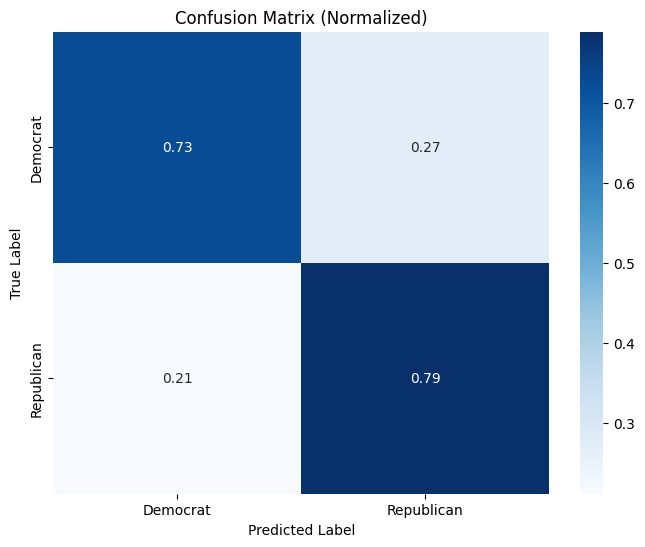

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=['Democrat', 'Republican'],
    yticklabels=['Democrat', 'Republican']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized)')
plt.show()

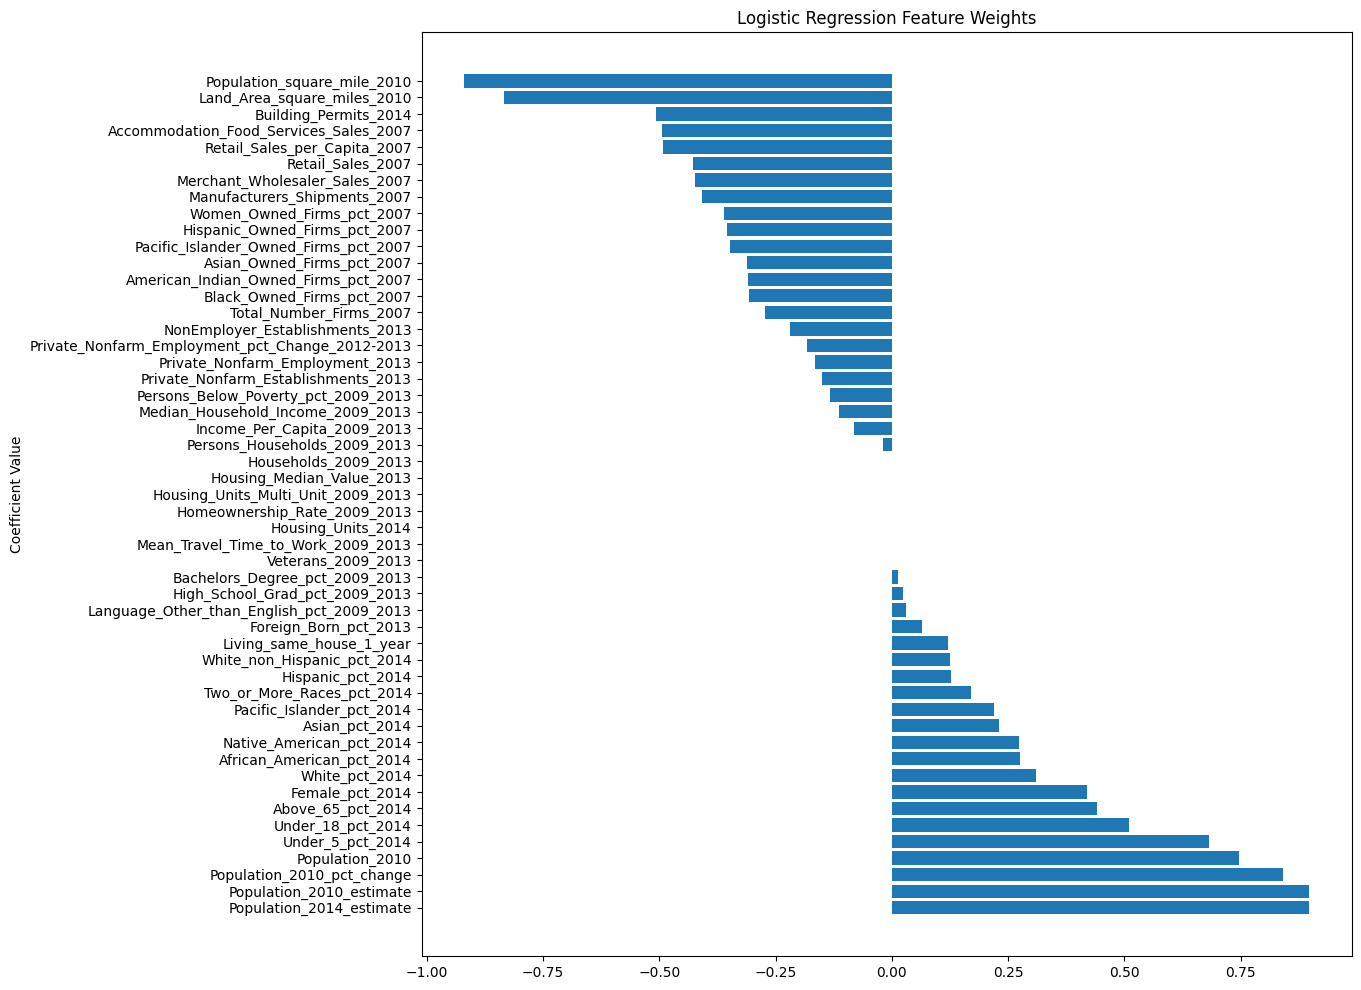

In [28]:
coeffs = logr.coef_[0]
sorted_indices = np.argsort(coeffs)[::-1]  # Sort indices in descending order

sorted_features = np.array(numeric_cols)[sorted_indices]
sorted_coeffs = coeffs[sorted_indices]

plt.figure(figsize=(12, 12))
plt.barh(numeric_cols, sorted_coeffs)
plt.ylabel("Coefficient Value")
plt.title("Logistic Regression Feature Weights")
plt.show()

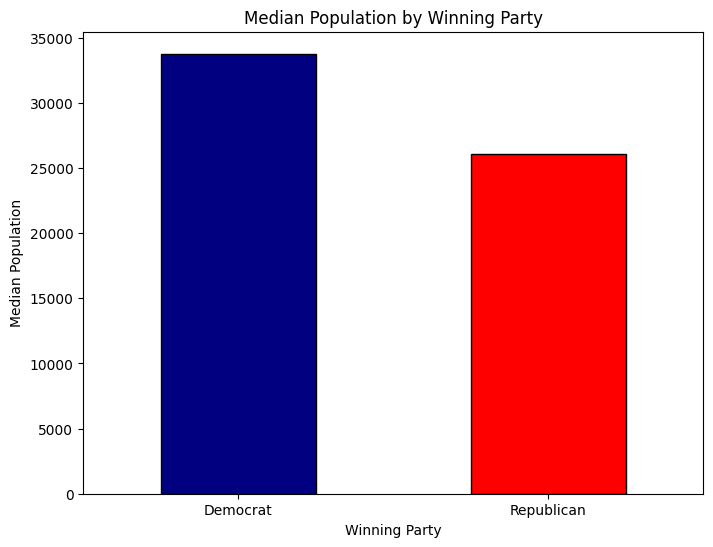

In [29]:
grouped_pop = merged_df.groupby("winner")["Population_2014_estimate"].median()

order = ["Democrat", "Republican"]
grouped_pop = grouped_pop.reindex(order)

plt.figure(figsize=(8, 6))
grouped_pop.plot(kind="bar", color=["navy", "red"], edgecolor="black")

plt.xlabel("Winning Party")
plt.ylabel("Median Population")
plt.title("Median Population by Winning Party")
plt.xticks(rotation=0)
plt.show()

## VIF Analysis

In [30]:
corr_matrix = merged_df[numeric_cols].corr().abs()
threshold = 0.8
G = nx.Graph()
G.add_nodes_from(numeric_cols)

In [31]:
# Add edges for pairs of columns above the threshold
for i in range(len(numeric_cols)):
    for j in range(i + 1, len(numeric_cols)):
        if corr_matrix.iloc[i, j] > threshold:
            G.add_edge(numeric_cols[i], numeric_cols[j])

In [32]:
connected_components = nx.connected_components(G)

# Convert each connected component (a set) into a list
high_corr_groups = [list(cc) for cc in connected_components if len(cc) > 1]

print("Highly correlated groups of features:")
for group in high_corr_groups:
    print(group)

Highly correlated groups of features:
['Merchant_Wholesaler_Sales_2007', 'Housing_Units_2014', 'Veterans_2009_2013', 'Households_2009_2013', 'Private_Nonfarm_Employment_2013', 'Manufacturers_Shipments_2007', 'Retail_Sales_2007', 'Population_2010', 'Population_2010_estimate', 'Total_Number_Firms_2007', 'Private_Nonfarm_Establishments_2013', 'Population_2014_estimate', 'Accommodation_Food_Services_Sales_2007', 'NonEmployer_Establishments_2013']
['Under_5_pct_2014', 'Under_18_pct_2014']
['African_American_pct_2014', 'White_pct_2014']
['Asian_pct_2014', 'Asian_Owned_Firms_pct_2007']
['Pacific_Islander_pct_2014', 'Pacific_Islander_Owned_Firms_pct_2007']
['Language_Other_than_English_pct_2009_2013', 'Foreign_Born_pct_2013', 'Hispanic_pct_2014']
['Median_Household_Income_2009_2013', 'Income_Per_Capita_2009_2013']


In [33]:
merged_df_clean = merged_df.copy()

# --- Group 1: County Size Variables ---
# These columns are highly correlated because they all measure county size/economic activity.
size_columns = [
    'Population_2010', 'Private_Nonfarm_Employment_2013', 'Households_2009_2013',
    'Retail_Sales_2007', 'Private_Nonfarm_Establishments_2013', 'Population_2014_estimate',
    'Veterans_2009_2013', 'Total_Number_Firms_2007', 'NonEmployer_Establishments_2013',
    'Merchant_Wholesaler_Sales_2007', 'Population_2010_estimate', 'Housing_Units_2014',
    'Accommodation_Food_Services_Sales_2007', 'Manufacturers_Shipments_2007'
]

# Standardize the size-related columns (fill missing with 0, or consider using mean imputation)
scaler = StandardScaler()
size_data = merged_df_clean[size_columns].fillna(0)
size_data_scaled = scaler.fit_transform(size_data)

# Use PCA to reduce to one composite index
pca = PCA(n_components=1)
merged_df_clean["County_Size_Index"] = pca.fit_transform(size_data_scaled)
merged_df_clean.drop(columns=size_columns, inplace=True)

# --- Group 2: Child Demographics ---
if 'Under_18_pct_2014' in merged_df_clean.columns and 'Under_5_pct_2014' in merged_df_clean.columns:
    merged_df_clean["Youth_pct_2014"] = merged_df_clean["Under_18_pct_2014"] + merged_df_clean["Under_5_pct_2014"]
    merged_df_clean.drop(columns=['Under_5_pct_2014', 'Under_18_pct_2014'], inplace=True)

# --- Group 3: Income Measures ---
income_cols = ['Median_Household_Income_2009_2013', 'Income_Per_Capita_2009_2013']
if all(col in merged_df_clean.columns for col in income_cols):
    merged_df_clean["Income_Index"] = merged_df_clean[income_cols].mean(axis=1)
    merged_df_clean.drop(columns=income_cols, inplace=True)

In [34]:
winner_counts = merged_df_clean["winner"].value_counts()
winner_percent = (winner_counts / winner_counts.sum()) * 100

summary_table = pd.DataFrame({
    "Count": winner_counts,
    "Percentage": winner_percent.round(2)
})

summary_table["Percentage"] = summary_table["Percentage"].astype(str) + "%"

print(summary_table)

            Count Percentage
winner                      
Republican   2090     77.09%
Democrat      621     22.91%


## Logistic Regression Model after VIF

In [35]:
numeric_cols_2 = merged_df_clean.select_dtypes(include=['int64', 'float64']).columns
numeric_cols_2 = numeric_cols_2.drop(to_drop, errors='ignore')
numeric_cols_2 = numeric_cols_2.drop('fips_int_', errors='ignore')

In [36]:
merged_df_clean = merged_df_clean.dropna()

In [37]:
X = merged_df_clean[numeric_cols_2]
y = merged_df_clean['winner']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

logr = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l1', solver='liblinear')
logr.fit(X_train, y_train)

y_pred = logr.predict(X_test)

In [38]:
# Predict probabilities for the positive class (e.g., "Republican")
y_probs = logr.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
precision = precision_score(y_test, y_pred, pos_label='Republican')
recall = recall_score(y_test, y_pred, pos_label='Republican')
f1 = f1_score(y_test, y_pred, pos_label='Republican')
auroc = roc_auc_score(y_test, y_probs)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUROC:", auroc)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7605893186003683
Precision: 0.8967391304347826
Recall: 0.7819905213270142
F1 Score: 0.8354430379746836
AUROC: 0.8153813011632917
Confusion Matrix:
[[0.68595041 0.31404959]
 [0.21800948 0.78199052]]


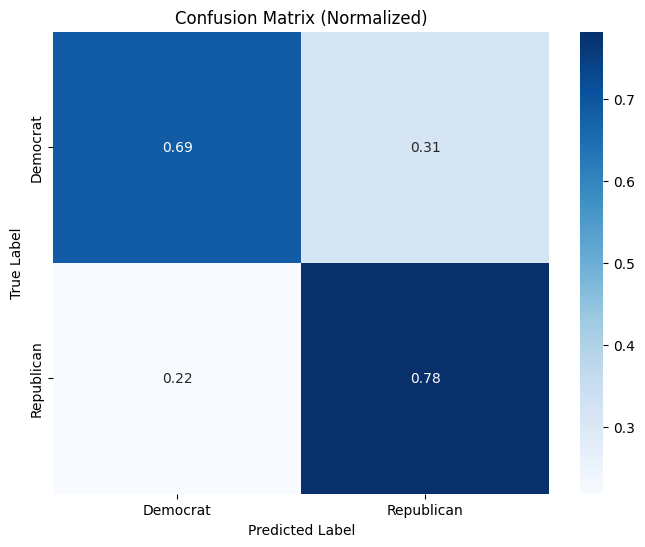

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=['Democrat', 'Republican'],
    yticklabels=['Democrat', 'Republican']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized)')
plt.show()

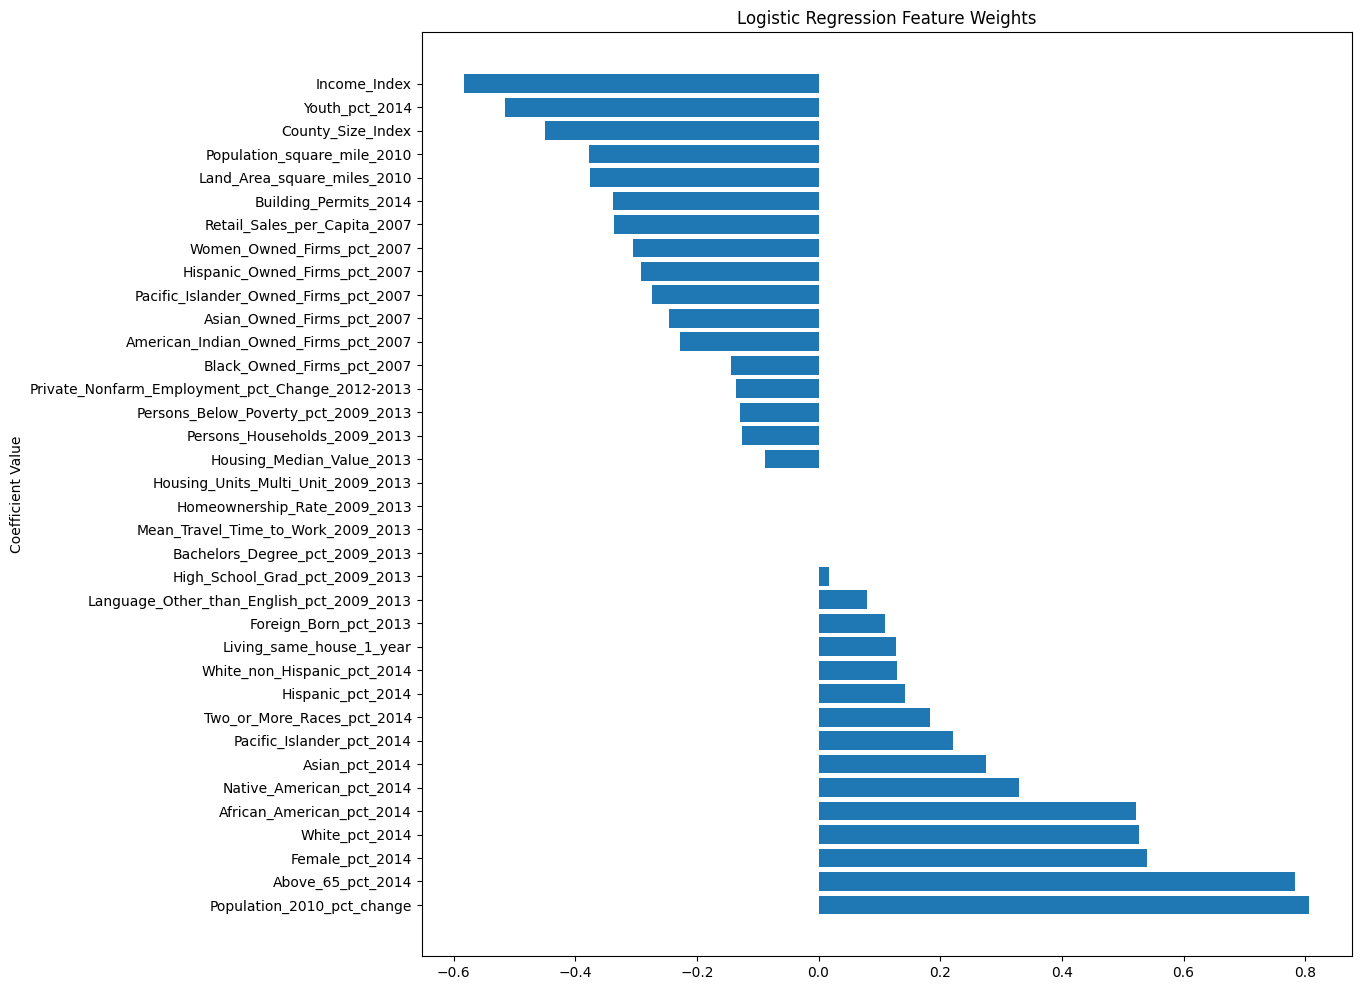

In [40]:
coeffs = logr.coef_[0]
sorted_indices = np.argsort(coeffs)[::-1]  # Sort indices in descending order

sorted_features = np.array(numeric_cols_2)[sorted_indices]
sorted_coeffs = coeffs[sorted_indices]

plt.figure(figsize=(12, 12))
plt.barh(numeric_cols_2, sorted_coeffs)
plt.ylabel("Coefficient Value")
plt.title("Logistic Regression Feature Weights")
plt.show()

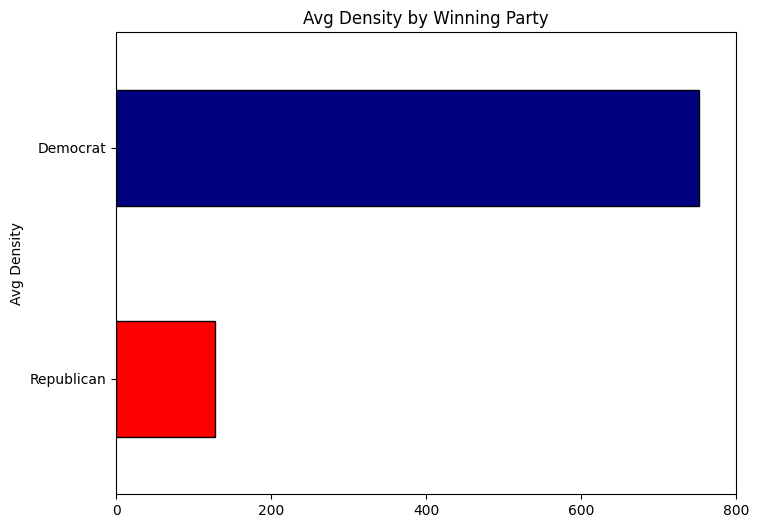

In [41]:
plt.figure(figsize=(8, 6))
grouped_density = merged_df_clean.groupby("winner")["Population_square_mile_2010"].mean()

order = ["Democrat", "Republican"]
grouped_density = grouped_density.reindex(order)

grouped_density.plot(
    kind="barh",
    color=["navy", "red"],
    edgecolor="black"
)

plt.xlim(0, 800)
plt.xticks(np.arange(0, 801, 200))

plt.gca().invert_yaxis()

plt.ylabel("Avg Density")
plt.title("Avg Density by Winning Party")
plt.show()

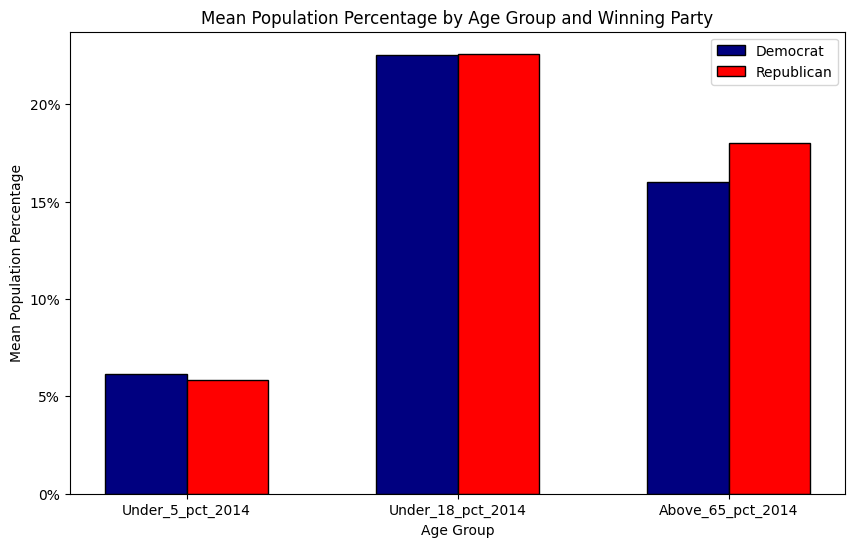

In [44]:
age_columns = ["Under_5_pct_2014", "Under_18_pct_2014", "Above_65_pct_2014"]
grouped_pop = merged_df.groupby("winner")[age_columns].mean()

order = ["Democrat", "Republican"]
grouped_pop = grouped_pop.reindex(order)

plt.figure(figsize=(10, 6))
bar_width = 0.3
x = np.arange(len(age_columns))

plt.bar(x - bar_width/2, grouped_pop.loc["Democrat"], width=bar_width, color="navy", label="Democrat", edgecolor="black")
plt.bar(x + bar_width/2, grouped_pop.loc["Republican"], width=bar_width, color="red", label="Republican", edgecolor="black")

plt.xticks(ticks=x, labels=age_columns, rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.xlabel("Age Group")
plt.ylabel("Mean Population Percentage")
plt.title("Mean Population Percentage by Age Group and Winning Party")
plt.legend()
plt.show()

In [48]:
total_dem_votes = merged_df_clean["votes_Democrat"].sum()
total_rep_votes = merged_df_clean["votes_Republican"].sum()
total_votes = total_dem_votes + total_rep_votes

dem_pct = (total_dem_votes / total_votes) * 100
rep_pct = (total_rep_votes / total_votes) * 100

vote_summary = pd.DataFrame({
    "Party": ["Democrat", "Republican"],
    "Total Votes": [total_dem_votes, total_rep_votes],
    "Percentage": [f"{dem_pct:.2f}%", f"{rep_pct:.2f}%"]
})

print(vote_summary)

        Party  Total Votes Percentage
0    Democrat   24334478.0     46.96%
1  Republican   27482459.0     53.04%
